# Netflix
Netflix je v poslední době velmi populární streamovací platforma a tak jsem vybral její téma pro vypracování statistické práce. Provedu nad daty dvě statistické metody. Pomocí první ověřím podle státní příslušnosti uživatelů ze vzorku, jak moc dobře náhodný je náš vzorek dat. Ve druhém bodě pak otestuji závislost mezi věkem a velikostí ceny předplatného.

Níže načteme do našeho python kódu knihovny a moduly, které budeme pro práci potřebovat:

In [1]:
from prettytable import PrettyTable

from scipy.stats import chisquare
from scipy.stats import linregress
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt

import numpy as np

import csv
from math import ceil, floor

## Data
Data jsou pořízené ze stránky kaggle.com. Vzorek obsahuje 2500 řádků, kde každý je složený popořadě z následujících sloupců: User ID (identifikátor uživatele), Subscription Type (typ předplatného), Monthly Revenue (defacto se jedná o cenu předplatného v dané zemi v dolarech), Join Date (datum vytvoření účtu uživatele), Last Payment Date (poslední datum, kdy byla provedena platba), Country (země původu), Age (věk), Gender (pohlaví), Device (nejčastěji používané zařízení uživatele), Plan Duration (na jakou dobu má uživatel předplaceno). 

Načtení a vizualizace dat:

In [2]:
tab = PrettyTable()
data = None #variable for accessing our data in other parts of notebook, it will be list of rows

with open("data/netflix-userbase.csv", newline="") as file:
    dict_reader = csv.DictReader(file)
    
    data = list(dict_reader)
    
    #pushing data to table
    tab.field_names = dict_reader.fieldnames
    
    for row in data:  
        tab.add_row(
            [
                row["User ID"],
                row["Subscription Type"],
                row["Monthly Revenue"],
                row["Join Date"],
                row["Last Payment Date"],
                row["Country"],
                row["Age"],
                row["Gender"],
                row["Device"],
                row["Plan Duration"]
            ]
        )

#printing table
print(tab.get_string(
    start=0, #sets boundaries for first and last rows we want to print out
    end=5,
    fields=["User ID", "Subscription Type", "Monthly Revenue", "Country", "Age"] #projection of some of the columns
))

+---------+-------------------+-----------------+----------------+-----+
| User ID | Subscription Type | Monthly Revenue |    Country     | Age |
+---------+-------------------+-----------------+----------------+-----+
|    1    |       Basic       |        10       | United States  |  28 |
|    2    |      Premium      |        15       |     Canada     |  35 |
|    3    |      Standard     |        12       | United Kingdom |  42 |
|    4    |      Standard     |        12       |   Australia    |  51 |
|    5    |       Basic       |        10       |    Germany     |  33 |
+---------+-------------------+-----------------+----------------+-----+


Do notebooku se na šířku nevejdou všechny sloupce z datového souboru, takže jsem vyprojektoval pouze ty, které nás budou zajímat pro budoucí testy.

### Aktuální počty obyvatel
Dodatečně pro test dobré shody budeme potřebovat data o aktuálních počtech obyvatel, které jsem použil z wikipedie, konkrétně: https://cs.wikipedia.org/wiki/Seznam_států_světa_podle_počtu_obyvatel. Níže je seznam zemí, který nás bude zajímat, jelikož se nachází ve vzorku.

In [3]:
countries = []

#get countries from data
for row in data:
    country = row["Country"]
    
    if country not in countries:
        countries.append(country)

#print result
print("Countries from our data:")
for i in range(len(countries)):
    print("- ", countries[i])

Countries from our data:
-  United States
-  Canada
-  United Kingdom
-  Australia
-  Germany
-  France
-  Brazil
-  Mexico
-  Spain
-  Italy


A pro tyto země získáme následující pravděpodobnosti, že uživatel je dané národnosti vzhledem k celkovému počtu obyvatel:

- United states: 4.19%
- Canada: 0.48%
- United Kingdom: 0.85%
- Australia: 0.32%
- Germany: 1.05%
- France: 0.86%
- Brazil: 2.7%
- Mexico: 1.65%
- Spain: 0.55%
- Italy: 0.75%

A pokud výsledky přeškálujeme pouze pro výčet těchto států, dostaneme následující:

- United states: 31.27%
- Canada: 3.58%
- United Kingdom: 6.34%
- Australia: 2.39%
- Germany: 7.84%
- France: 6.42%
- Brazil: 20.15%
- Mexico: 12.31%
- Spain: 4.1%
- Italy: 5.6%

## Test náhodnosti dat
Pro tento test použijeme údaje o zemi původu uživatelů. Spočteme jaká je očekávaná četnost podle světových dat, že člověk pochází z dané země. A porovnáme s pozorovanou četností z našeho vzorku. Pro následné porovnání výsledků použijeme test dobré shody. Nulová hypotéza tedy bude, že máme dobře spravedlivý vzorek, nebo-li tedy vzorek obsahuje přímo úměrný počet obyvatel z jednotlivých zemí vzhledem k velikosti jejich populace. Alternativní hypotézou bude tvrzení říkající, že tato vlastnost ve vzorku naopak neplatí. Pro test ještě stanovíme hladinu významnosti $\alpha$ jako 5%.

Spočtěme nejprve tedy očekávané četnosti, podle procentuálních dat z wikipedie s tím, že výsledky zaokrouhlíme. Jelikož počty obyvatel jsou dost rozdílné, tak u velkých států zaokrouhlíme výsledek na spodní celou část čísla a u zbylích použijeme horní celou část čísla. Jejich součet pak i bude dávat dohromady 2500, což potřebujeme v budoucím testu:

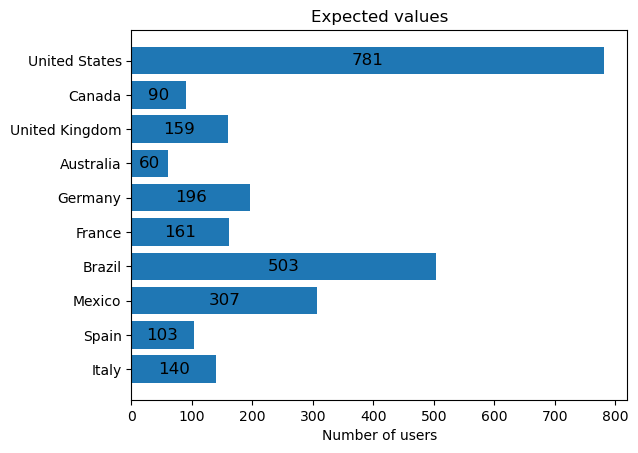

In [4]:
#calculating expected values with percents from our precalculated data for states
n = 2500
expected = [
    floor(n*0.3127),
    ceil(n*0.0358),
    ceil(n*0.0634),
    ceil(n*0.0239),
    ceil(n*0.0784),
    ceil(n*0.0642),
    floor(n*0.2015),
    floor(n*0.1231),
    ceil(n*0.041),
    ceil(n*0.056)
]

#creating of plot
fig_exp, ax_exp = plt.subplots(1, 1)

hbars_exp = ax_exp.barh(countries, expected)

ax_exp.set_title("Expected values")
ax_exp.invert_yaxis()
ax_exp.set_xlabel("Number of users")

ax_exp.bar_label(
    hbars_exp,
    labels=expected,
    color="black",
    fontsize=12,
    label_type="center"
)

#printing plot
plt.show()

Nýní se podíváme na pozorované hodnoty z našeho vzorku:

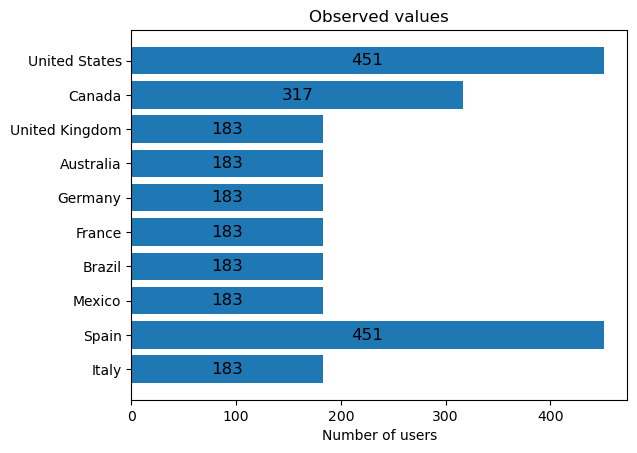

In [5]:
#counting values of countries from our data set
observed = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for row in data:
    country = row["Country"]
    if country == "United States":
        observed[0] += 1
    elif country == "Canada":
        observed[1] += 1
    elif country == "United Kingdom":
        observed[2] += 1
    elif country == "Australia":
        observed[3] += 1
    elif country == "Germany":
        observed[4] += 1
    elif country == "France":
        observed[5] += 1
    elif country == "Brazil":
        observed[6] += 1
    elif country == "Mexico":
        observed[7] += 1
    elif country == "Spain":
        observed[8] += 1
    elif country == "Italy":
        observed[9] += 1

#creating plot of observed data
fig_obs, ax_obs = plt.subplots(1, 1)

hbars_obs = ax_obs.barh(countries, observed)

ax_obs.set_title("Observed values")
ax_obs.invert_yaxis()
ax_obs.set_xlabel("Number of users")

ax_obs.bar_label(
    hbars_obs,
    labels=observed,
    color="black",
    fontsize=12,
    label_type="center"
)

#printing plot
plt.show()

Provádíme tedy 2500 pokusů (bereme 2500 lidí) a můžeme tak tyto data popsat multinomickým rozdělením s parametry (2500, 0.3127, 0.0358, ..., 0.056), jelikož vybereme-li jedince, pak předpokládáme, že je jedné národnosti a zároveň není jiné. A pokud počítáme pravděpodobnost, že je ve vzorku určitý počet ruzných národností, tak ještě musíme uvažovat jejich uspořádání a do vzorce pro výpočet pravděpodobnosti se nám tak dostane i příslušný binomický koeficient.

Můžeme tedy s těmito naměřenými daty provézt $\chi^2$ test:

In [6]:
chi_test = chisquare(f_obs=observed, f_exp=expected)

print("Results:")
print("- Score of X-squared is:", chi_test.statistic, sep=" ")
print("- p-value is:", chi_test.pvalue, sep=" ")

Results:
- Score of X-squared is: 2414.2595142794603
- p-value is: 0.0


### Závěr testu
Jelikož hodnota $\chi^2$ testu vyšla přibližně 2414 a zamítací hodnota podle tabulek byla 16.919 (pro 9 stupňů volnosti a $\alpha = 0.05$), tak zamítáme nulovou hypotézu a tudíž náš vzorek četností uživatelů vůbec nedpovídá poměrům počtů obyvatel těchto jednotlivých států. Vzorek tedy není dobře náhodný, pokud budeme zkoumat zastoupení uživatelů z jednotlivých států.

Jelikož je výsledek testu o tolik větší než požadovaná hranice, tak p-hodnota testu vyšla prakticky nulová. A také tedy platí, že p-hodnota je o dost menší, než $\alpha$ a tedy bychom mohli zamítat také z tohoto důvodu.

Extrémní výsledky testu budou nejspíš způsobeny také tím, že vzorek ze 2500 lidí je poměrně malý. Neboť Netflix bude mít miliony uživatelů a najít 2500 lidí jedné národnosti není tak složité pro jakýkoli stát. Čím větší vzorek bude, tím více bych čekal, že se do něj ovšem bude promítat závislost na počtu obyvatel v jednotlivých státech. Pokud bude vzorek mít třeba 11 milionů uživatelů, tak zajistit, aby byli všichni české národnosti, by bylo prakticky nemožné.

## Test závisloti ceny předplatného a věku uživatelů
K tomuto testu použijeme metodu lineární regrese. Provedeme opět test hypotéz. Nulová hypotéza tedy bude říkat, že mezi cenou předplatného a věkem uživatele je lineární závislost. Alternativní hypotéza bude opět říkat, že tato skutečnost neplatí. Ještě zavedeme pro test opět hladinu významnosti $\alpha$ jako 5%.

Ceny předplatného jsou v tabulce s daty schované ve sloupci Monthly Revenue. Jde o měsíční příjem netflixu, který uživatel generuje. Což je defacto cena měsíčního předplatného. Věk získáme z patřičného sloupce v tabulce také.

Takto vypadají naše data:

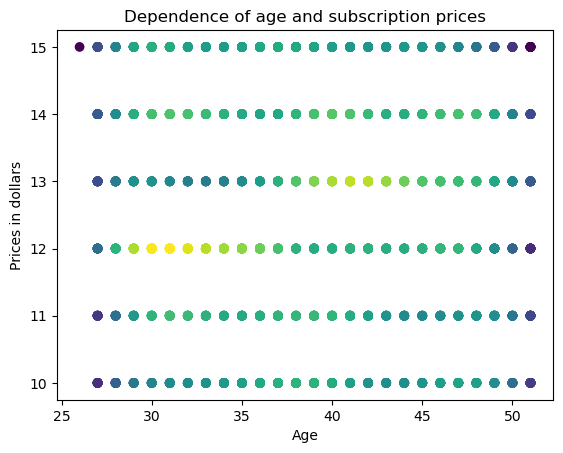

In [7]:
#getting our data
ages = []
prices = []
for row in data:
    ages.append(int(row["Age"]))
    prices.append(int(row["Monthly Revenue"]))

#calcuating density of points
points = np.vstack([ages, prices])
density = gaussian_kde(points)(points)

#creating graph
fig_reg, ax_reg = plt.subplots()

ax_reg.scatter(ages, prices, c=density)

ax_reg.set_title("Dependence of age and subscription prices")
ax_reg.set_ylabel("Prices in dollars")
ax_reg.set_xlabel("Age")

plt.show()

Barva bodů z grafu výše určuje jejich četnost, kde nejčetnější body mají žluté zbarvení a ty nejméně početné tmavě modré.

Provedeme tedy nad daty metodu lineární regrese:

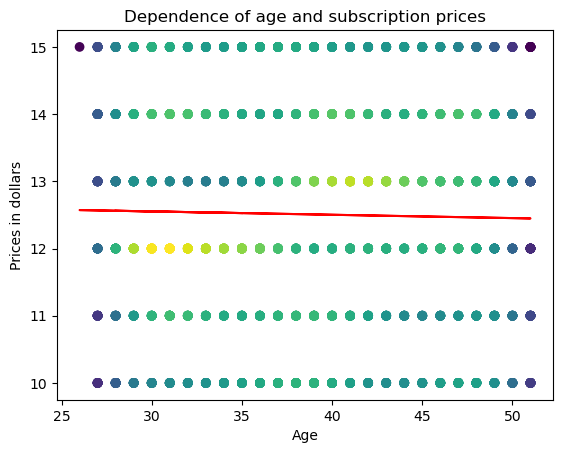

In [8]:
#calculates linear regresion
res_reg = linregress(ages, prices)

#creates graph
fig_reg, ax_reg = plt.subplots()

ax_reg.scatter(ages, prices, c=density)

ax_reg.set_title("Dependence of age and subscription prices")
ax_reg.set_ylabel("Prices in dollars")
ax_reg.set_xlabel("Age")

#creates line of linear regression
ax_reg.plot(np.array(ages),  res_reg.slope* np.array(ages) + res_reg.intercept, color="red")

#prints graph
plt.show()

Červená přímka je zde vizualizací námi spočtené lineární regrese.

In [9]:
#prints results of linear regression
print("Results:")
print("- p-value is: ", res_reg.pvalue)

Results:
- p-value is:  0.2906245022256865


### Závěr testu
Jelikož p-hodnota testu je větší, než naše hladina významnosti testu, tak nemůžeme lineární závislost mezi věkem a cenou předplatného vyvrátit. Nulová hypotéza je tedy platnou a mezi věkem a cenou předplatného určitá lineární závislost je. I když vzhledem k tomu, že velikost p-hodnoty není zase tak vysoká, tak lineární závislost není úplně jistá. Což je poznat už z toho, že data jsou hodně rozsypaná mezi všechny věkové skupiny i různé ceny předplatného.

## Celkový závěr
U testu náhodnosti dat jsem od začátku čekal, že ten vzorek bude nějak zkreslený. Vysvětluju si to tak, že třeba služba oslovuje uživatele z různých zemí více (aplikace je jen v nějakých jazycích, ...), nebo třeba někde nemusí být služba vůbec dostupná. Původně jsem chtěl test provést více obecně a zahrnout do něj i státy, které ve vzorku vůbec nejsou (tedy třeba Čínu atd.), což by ovšem s výsledky ještě více zamíchalo a pro velmi malé četnosti navíc pak test $\chi^2$ nevychází moc dobře.

Test lineární závislosti mě vlastně dvakrát překvapil. Nejprve jsem očekával, že by tam nějaká lineární závislost být mohla, ale pak jsem si zobrazil data do grafu (ještě bez barevného zobrazení četnosti) a dost jsem znejistěl. Nakonec po přidání hustoty jednotlivých bodů (kdy konečně graf říkal něco zajímavého o datech) a spočtení testu lineární regrese, mě vlastně překvapilo, že tendence té závislosti je klesající a ne roustoucí. Očekával jsem, že starší jedinci budou mít na zakoupení dražšího předplatného více finančních prostředků a tudíž budou ochotni platit více. Ale naopak dražší předlpatné si dopřávají mladší jedinci asi z důvodu většího technologického nadšení, nebo třeba lepší filmové nabídky pro jejich věkovou skupinu.

Bohužel jsem během vytváření práce zjistil na stránkách kaggle, že tato datová sada byla nějakým způsobem simulovaná a nepochází přímo z datových serverů firmy Netflix. Což by třeba i mohlo vysvětlovat extrémní výsledky prvního testu, i když si zpětně nemyslím, že 2500 uživatelů je pro tento test dostatečné velký vzorek, jak už jsem zmiňoval v závěru prvního testu.